# IceNet Validation
- Ryan Chan (Research Software Engineer, The Alan Turing Institute)
- Oliver Strickson (Senior Research Software Engineer, The Alan Turing Institute)
- James Byrne (Research Software Engineer, British Antarctic Survey)
- Tom Andersson (Data Scientist, British Antarctic Survey)

## Summary
This notebook illustrates the command line interface (CLI) utilitities that are available natively from the [IceNet library](https://github.com/icenet-ai/icenet) which can be used to compute metrics and create plots for evaluation of sea-ice concentration (SIC) forecasts.

In this notebook, we will illustrate how to compute and plot metrics for validating IceNet forecasts using the IceNet library Pythonically (i.e. using the functions in Python) and how to use the CLI commands which essentially creates a wrapper around the relevant IceNet functions to produce and save plots.

We note that this notebook is not a proper evaluation of IceNet as a model, but the main purpose is to illustrate how we can use the validation commands in the IceNet library to evaluate forecasts made by the model.

## Prerequistes
In order to run this notebook, we assume that you have a working IceNet environment and pipeline (the details of which can be found in the [`icenet-pipeline` repository](https://github.com/icenet-ai/icenet-pipeline) which illustrates the operational execution of the IceNet model). Furthermore, as the focus of the notebook is to illustrate commands to _validate_ (or _evaluate_) sea-ice concentration forecasts (made with IceNet or otherwise), we will also assume that the user has created forecasts (stored in NetCDF files, i.e. files with `.nc` extension). For details on how to make forecasts with IceNet, please see notebooks [1](https://github.com/icenet-ai/icenet-notebooks/blob/main/01.cli_demonstration.ipynb), [2](https://github.com/icenet-ai/icenet-notebooks/blob/main/02.data_and_forecasts.ipynb) and [3](https://github.com/icenet-ai/icenet-notebooks/blob/main/03.library_usage.ipynb) in the [`icenet-notebooks` repository](https://github.com/icenet-ai/icenet-notebooks).

In [74]:
import os
import numpy as np 
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import timedelta

# Import some useful IceNet functions
from icenet.data.sic.mask import Masks
from icenet.plotting.utils import (get_obs_da,
                                   get_forecast_ds,
                                   filter_ds_by_obs,
                                   get_seas_forecast_da)

# Import core functions to compute and plot various metrics
from icenet.plotting.forecast import (sic_error_video,
                                      process_probes,
                                      sic_error_local_plots,
                                      compute_metrics,
                                      compute_binary_accuracy,
                                      compute_sea_ice_extent_error,
                                      compute_metrics_leadtime_avg,
                                      plot_metrics,
                                      plot_binary_accuracy,
                                      plot_sea_ice_extent_error,
                                      plot_metrics_leadtime_avg)

# Allows us to display images that we will save as .png files
from IPython.display import Image

# We also set the logging level so that we get some feedback from the API
import logging
logging.basicConfig(level=logging.INFO)

%matplotlib inline

As noted above in the prerequistes, we assume that you have a working IceNet environment and have a directory structure like the one in the [`icenet-pipeline` repository](https://github.com/icenet-ai/icenet-pipeline), to run this notebook, change the below cell to the appropriate path for your machine.

In [2]:
os.chdir("/data/hpcdata/users/rychan/icenet/")

In this working directory, there should be a `data/` folder which stores some IceNet data (or is a symlink to it).

In [3]:
os.listdir("./data/")

['osisaf',
 'era5',
 'masks',
 'mars.hres',
 'cmip6.MRI-ESM2-0.r1i1p1f1',
 'oras5',
 'mars.seas']

Furthermore, we assume that the forecasts are stored in a NetCDF (`.nc`) file. For this particular notebook, we have trained a model where the training dataset is data from **1990-01-01** to  **2013-12-31** and the validation dataset is data from **2016-09-01** to **2017-05-31**. After training, we initialise the model every single day between **2018-01-01** and **2020-12-31** to predict the next 93 days from the initialisation date, and we're just focusing on the Northern hemisphere.

In particular, for each day between **2018-01-01** and **2020-12-31**, we make a daily SIC forecast for next 93 days.

In [4]:
forecast_file = "/users/rychan/icenet/pipeline/results/predict/daily_2018_2020_north.nc"
fc_ds = xr.open_dataset(forecast_file)
fc_ds

<xarray.Dataset>
Dimensions:                 (time: 1096, yc: 432, xc: 432, leadtime: 93)
Coordinates:
  * time                    (time) datetime64[ns] 2018-01-01 ... 2020-12-31
  * leadtime                (leadtime) int64 1 2 3 4 5 6 7 ... 88 89 90 91 92 93
    forecast_date           (time, leadtime) datetime64[ns] ...
  * xc                      (xc) float64 -5.388e+03 -5.362e+03 ... 5.388e+03
  * yc                      (yc) float64 5.388e+03 5.362e+03 ... -5.388e+03
    lat                     (yc, xc) float32 ...
    lon                     (yc, xc) float32 ...
Data variables:
    Lambert_Azimuthal_Grid  int32 ...
    sic_mean                (time, yc, xc, leadtime) float32 ...
    sic_stddev              (time, yc, xc, leadtime) float32 ...
Attributes: (12/36)
    Conventions:               CF-1.6 ACDD-1.3
    comments:                  
    creator_email:             jambyr@bas.ac.uk
    creator_institution:       British Antarctic Survey
    creator_name:              James Byrne
    creator_url:               www.bas.ac.uk
    ...                        ...
    summary:                   \n            This is an output of sea ice con...
    time_coverage_start:       
    time_coverage_end:         
    time_coverage_duration:    P1D
    time_coverage_resolution:  P1D
    title:                     Sea Ice Concentration Prediction

# Computing and plotting metrics for a forecasts from a particular date of interest

After loading in forecast file, we obtain an `xarray.Dataset` object where we have forecasts initialised at each date between  **2018-01-01** and **2020-12-31**, and for each of those dates, we have a forecast of the SIC for each grid location at each leadtime $(1, 2, ..., 93)$.

In this section, we look at how we can compute metrics to evaluate a forecast for a particular day of interest. For the purposes of this section, we focus on the forecasts made after initiailising the model from **2020-03-01** (so we're predicting dates between **2020-03-02** to **2020-06-02** (the initialisation date + 93 leadtime days)).

### Setup for evaluating forecasts initialised at some date of interest

- IceNet relies on some generated masks which we assume are in the `data/` repository (see [Notebook 1](https://github.com/icenet-ai/icenet-notebooks/blob/main/01.cli_demonstration.ipynb) in the [`icenet-notebooks` repository](https://github.com/icenet-ai/icenet-notebooks) for more details on how to automatically generate masks for training/prediction using the `icenet_data_masks` CLI command).
- We use the `get_forecast_ds` function from the IceNet library to obtain our `xarray.Dataset` object which stores our forecasts from the NetCDF forecast file for our particular date of interest.
- We use the `get_obs_da` function from the IceNet library to obtain our `xarray.Dataarray` object which stores the model's ground truth (OSISAF data) for the days we're forecasting for.
- We then need to filter our Forecast xarray.Dataset object to obtain the `xarray.Dataarray` object for which we can compare with and compute metrics for.
- We will store our produced plots in the `plot/` directory which will be created if it does not exist in our current working directory (and similarly we will save some metrics computed in the `metrics/` directory).

In [53]:
date_of_interest = pd.Timestamp("2020-03-01")
masks = Masks(north=True)
fc = get_forecast_ds(forecast_file=forecast_file,
                     forecast_date=date_of_interest)
obs = get_obs_da(hemisphere="north",
                 start_date=pd.to_datetime(date_of_interest) + timedelta(days=1),
                 end_date=pd.to_datetime(date_of_interest) + timedelta(days=int(fc.leadtime.max())))
fc = filter_ds_by_obs(fc, obs, date_of_interest)

if not os.path.exists("plot/"):
    os.makedirs("plot/")

if not os.path.exists("metrics/"):
    os.makedirs("metrics/")

INFO:root:Got files: ['./data/osisaf/north/siconca/2020.nc', './data/osisaf/north/siconca/2021.nc']
INFO:root:Starting index will be 0 for 2020-12-01 00:00:00 - 2021-03-03 00:00:00


### SIC error animations

In [72]:
sic_error_video(fc_da=fc,
                obs_da=obs,
                land_mask=masks.get_land_mask(),
                output_path="plot/sic_error.mp4")

INFO:root:Saving to plot/sic_error.mp4
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 2400x900 -pix_fmt rgba -r 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y plot/sic_error.mp4
/data/hpcdata/users/rychan/icenet/icenet_fork/icenet/plotting/forecast.py:972: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  animation.save(output_path,


Note that we could've accomplished the same task by using the `icenet_plot_sic_error` command:

In [73]:
!icenet_plot_sic_error -h

2023-03-14 18:49:08.667403: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 18:49:08.824653: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
usage: icenet_plot_sic_error [-h] [-o OUTPUT_PATH] [-v] [-r REGION]
                             {north,south} forecast_file forecast_date

positional arguments:
  {north,south}
  forecast_file
  forecast_date

optional arguments:
  -h, --help            show this help message and exit
  -o OUTPUT_PATH, --output-path OUTPUT_PATH
  -v, --verbo

In [ ]:
!icenet_plot_sic_error north "/users/rychan/icenet/pipeline/results/predict/daily_2018_2020_north.nc" "2020-03-01"

### SIC error at a particular location

[<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>]

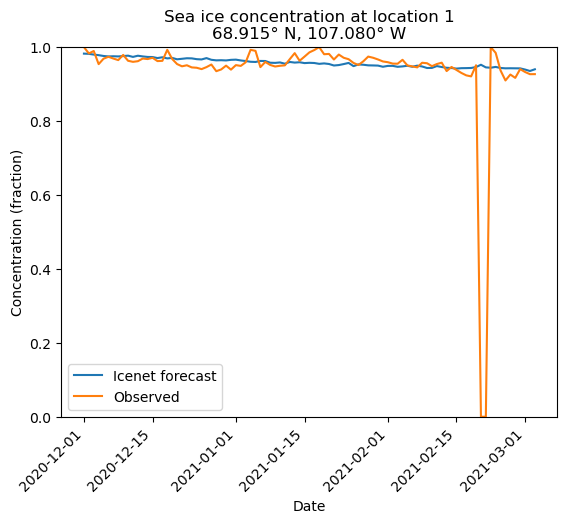

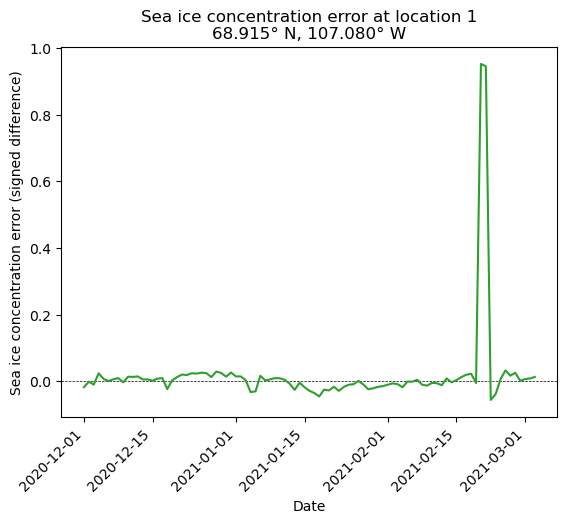

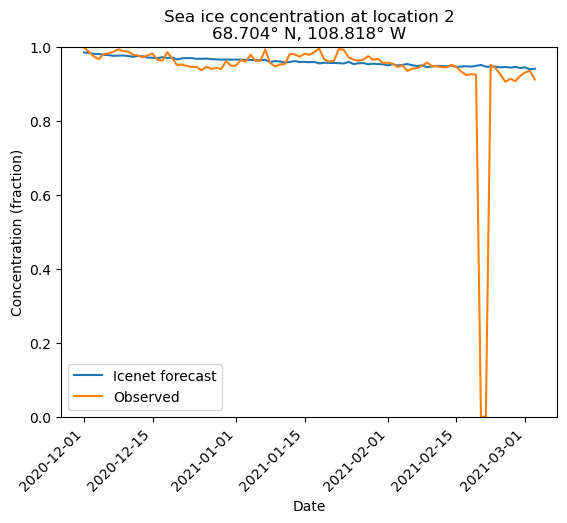

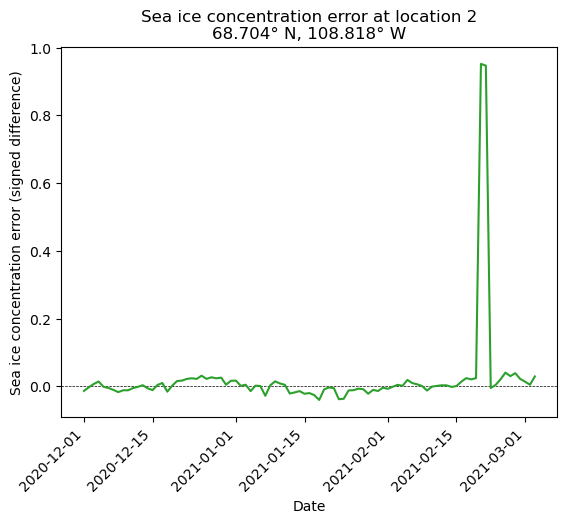

In [76]:
probes = np.array([[126, 188], [126, 185]])
fc_probes, obs_probes = process_probes(probes=probes, data=[fc, obs])
sic_error_local_plots(fc_da=fc_probes,
                      obs_da=obs_probes,
                      output_path=None)

In [77]:
!icenet_plot_sic_error_local -h

2023-03-14 18:56:23.634999: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 18:56:23.791433: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
usage: icenet_plot_sic_error_local [-h] [-o OUTPUT_PATH] [-v] [-r REGION]
                                   [-p LOCATION]
                                   {north,south} forecast_file forecast_date

positional arguments:
  {north,south}
  forecast_file
  forecast_date

optional arguments:
  -h, --help            show this help message and e

In [ ]:
!icenet_plot_sic_error_local north "/users/rychan/icenet/pipeline/results/predict/daily_2018_2020_north.nc" "2020-03-01"

### Metrics based on SIC error

In [54]:
fc_mse = compute_metrics(metrics=["MSE"],
                         masks=masks,
                         fc_da=fc,
                         obs_da=obs)
fc_mse

{'MSE': <xarray.DataArray (time: 93)>
 dask.array<truediv, shape=(93,), dtype=float64, chunksize=(62,), chunktype=numpy.ndarray>
 Coordinates:
     Lambert_Azimuthal_Grid  int32 -2147483647
     forecast_date           (time) datetime64[ns] 2020-12-01 ... 2021-03-03
   * time                    (time) datetime64[ns] 2020-12-01 ... 2021-03-03}

In [55]:
fc_mse["MSE"].values

array([  26.81162976,   43.61729452,   44.77416916,   47.51860306,
         62.6564778 ,   66.2358769 ,   69.68639684,   69.45816448,
         79.74506997,   84.77323963,   97.42515408,  106.76679085,
        103.85931333,  102.90168528,  100.59199545,   94.06902699,
         95.47515615,   85.45880051,   88.24540293,   93.12750937,
         89.2294014 ,   85.78065637,   82.01470619,   86.30895399,
         87.36552456,   89.42663192,  106.05689076,  112.44305261,
        110.6093732 ,  110.81625502,  109.12706053,  105.0903797 ,
        112.75759289,  118.74745738,  127.54956095,  131.97225362,
        136.44299686,  126.612143  ,  124.00926679,  111.96786932,
        116.14950099,  117.59089498,  114.66019984,  120.35644702,
        103.50055048,  102.63044821,   97.32092742,   87.10974292,
         87.21209692,   89.57865248,  103.92937685,  123.71394144,
        138.66688925,  154.47373135,  160.80574446,  155.31439185,
        159.15707584,  155.86659295,  155.62933058,  158.97698

In [61]:
obs.time

<xarray.DataArray 'time' (time: 93)>
array(['2020-12-01T00:00:00.000000000', '2020-12-02T00:00:00.000000000',
       '2020-12-03T00:00:00.000000000', '2020-12-04T00:00:00.000000000',
       '2020-12-05T00:00:00.000000000', '2020-12-06T00:00:00.000000000',
       '2020-12-07T00:00:00.000000000', '2020-12-08T00:00:00.000000000',
       '2020-12-09T00:00:00.000000000', '2020-12-10T00:00:00.000000000',
       '2020-12-11T00:00:00.000000000', '2020-12-12T00:00:00.000000000',
       '2020-12-13T00:00:00.000000000', '2020-12-14T00:00:00.000000000',
       '2020-12-15T00:00:00.000000000', '2020-12-16T00:00:00.000000000',
       '2020-12-17T00:00:00.000000000', '2020-12-18T00:00:00.000000000',
       '2020-12-19T00:00:00.000000000', '2020-12-20T00:00:00.000000000',
       '2020-12-21T00:00:00.000000000', '2020-12-22T00:00:00.000000000',
       '2020-12-23T00:00:00.000000000', '2020-12-24T00:00:00.000000000',
       '2020-12-25T00:00:00.000000000', '2020-12-26T00:00:00.000000000',
       '2020-12-27T00:00:00.000000000', '2020-12-28T00:00:00.000000000',
       '2020-12-29T00:00:00.000000000', '2020-12-30T00:00:00.000000000',
       '2020-12-31T00:00:00.000000000', '2021-01-01T00:00:00.000000000',
       '2021-01-02T00:00:00.000000000', '2021-01-03T00:00:00.000000000',
       '2021-01-04T00:00:00.000000000', '2021-01-05T00:00:00.000000000',
       '2021-01-06T00:00:00.000000000', '2021-01-07T00:00:00.000000000',
       '2021-01-08T00:00:00.000000000', '2021-01-09T00:00:00.000000000',
       '2021-01-10T00:00:00.000000000', '2021-01-11T00:00:00.000000000',
       '2021-01-12T00:00:00.000000000', '2021-01-13T00:00:00.000000000',
       '2021-01-14T00:00:00.000000000', '2021-01-15T00:00:00.000000000',
       '2021-01-16T00:00:00.000000000', '2021-01-17T00:00:00.000000000',
       '2021-01-18T00:00:00.000000000', '2021-01-19T00:00:00.000000000',
       '2021-01-20T00:00:00.000000000', '2021-01-21T00:00:00.000000000',
       '2021-01-22T00:00:00.000000000', '2021-01-23T00:00:00.000000000',
       '2021-01-24T00:00:00.000000000', '2021-01-25T00:00:00.000000000',
       '2021-01-26T00:00:00.000000000', '2021-01-27T00:00:00.000000000',
       '2021-01-28T00:00:00.000000000', '2021-01-29T00:00:00.000000000',
       '2021-01-30T00:00:00.000000000', '2021-01-31T00:00:00.000000000',
       '2021-02-01T00:00:00.000000000', '2021-02-02T00:00:00.000000000',
       '2021-02-03T00:00:00.000000000', '2021-02-04T00:00:00.000000000',
       '2021-02-05T00:00:00.000000000', '2021-02-06T00:00:00.000000000',
       '2021-02-07T00:00:00.000000000', '2021-02-08T00:00:00.000000000',
       '2021-02-09T00:00:00.000000000', '2021-02-10T00:00:00.000000000',
       '2021-02-11T00:00:00.000000000', '2021-02-12T00:00:00.000000000',
       '2021-02-13T00:00:00.000000000', '2021-02-14T00:00:00.000000000',
       '2021-02-15T00:00:00.000000000', '2021-02-16T00:00:00.000000000',
       '2021-02-17T00:00:00.000000000', '2021-02-18T00:00:00.000000000',
       '2021-02-19T00:00:00.000000000', '2021-02-20T00:00:00.000000000',
       '2021-02-21T00:00:00.000000000', '2021-02-22T00:00:00.000000000',
       '2021-02-23T00:00:00.000000000', '2021-02-24T00:00:00.000000000',
       '2021-02-25T00:00:00.000000000', '2021-02-26T00:00:00.000000000',
       '2021-02-27T00:00:00.000000000', '2021-02-28T00:00:00.000000000',
       '2021-03-01T00:00:00.000000000', '2021-03-02T00:00:00.000000000',
       '2021-03-03T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-12-01 2020-12-02 ... 2021-03-03

INFO:root:Saving to plot/MSE.png


({'RMSE': <xarray.DataArray (time: 93)>
  dask.array<sqrt, shape=(93,), dtype=float64, chunksize=(62,), chunktype=numpy.ndarray>
  Coordinates:
      Lambert_Azimuthal_Grid  int32 -2147483647
      forecast_date           (time) datetime64[ns] 2020-12-01 ... 2021-03-03
    * time                    (time) datetime64[ns] 2020-12-01 ... 2021-03-03},
 None)

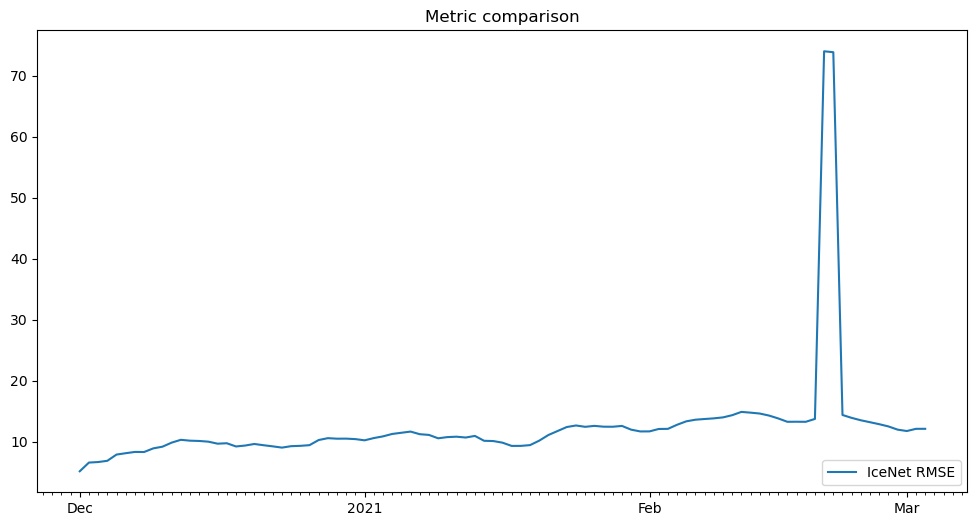

In [62]:
plot_metrics(metrics=["RMSE"],
             masks=masks,
             fc_da=fc,
             obs_da=obs, 
             cmp_da=None,
             output_path="plot/MSE.png")

In [79]:
!icenet_plot_metrics -h

2023-03-14 18:57:19.761023: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 18:57:19.931826: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
usage: icenet_plot_metrics [-h] [-o OUTPUT_PATH] [-v] [-r REGION] [-b] [-e]
                           [-m METRICS] [-s]
                           {north,south} forecast_file forecast_date

positional arguments:
  {north,south}
  forecast_file
  forecast_date

optional arguments:
  -h, --help            show this help message and exit
  -o O

In [ ]:
!icenet_plot_metric north "/users/rychan/icenet/pipeline/results/predict/daily_2018_2020_north.nc" "2020-03-01" \
    -o "plot/MSE.png" \
    -m "MSE"

In [12]:
cmp = get_seas_forecast_da(hemisphere="north",
                           date=date_of_interest,
                           bias_correct=True)
cmp = cmp.assign_coords(dict(xc=cmp.xc / 1e3, yc=cmp.yc / 1e3))
cmp = cmp.isel(time=slice(1, None))

INFO:root:Got files: ['./data/osisaf/north/siconca/2010.nc', './data/osisaf/north/siconca/2011.nc', './data/osisaf/north/siconca/2012.nc', './data/osisaf/north/siconca/2013.nc', './data/osisaf/north/siconca/2014.nc', './data/osisaf/north/siconca/2015.nc', './data/osisaf/north/siconca/2016.nc', './data/osisaf/north/siconca/2017.nc', './data/osisaf/north/siconca/2018.nc', './data/osisaf/north/siconca/2019.nc', './data/osisaf/north/siconca/2020.nc', './data/osisaf/north/siconca/2021.nc', './data/osisaf/north/siconca/2022.nc', './data/osisaf/north/siconca/2023.nc']
INFO:root:Debiaser input ranges: obs 0.00 - 1.00, hist -0.00 - 1.00, fut 0.00 - 1.00
INFO:root:----- Running debiasing for variable: siconc -----
100%|██████████| 186624/186624 [00:12<00:00, 14396.71it/s]
INFO:root:Debiaser output range: -0.62 - 1.11
INFO:root:Returning SEAS data from ./data/mars.seas/north/siconca/20200301.nc from 2020-03-01 00:00:00


INFO:root:Saving to plot/MAE_RMSE_comp.png


({'MAE': <xarray.DataArray (time: 93)>
  dask.array<truediv, shape=(93,), dtype=float64, chunksize=(93,), chunktype=numpy.ndarray>
  Coordinates:
      Lambert_Azimuthal_Grid  int32 -2147483647
      forecast_date           (time) datetime64[ns] 2020-03-02 ... 2020-06-02
    * time                    (time) datetime64[ns] 2020-03-02 ... 2020-06-02,
  'RMSE': <xarray.DataArray (time: 93)>
  dask.array<sqrt, shape=(93,), dtype=float64, chunksize=(93,), chunktype=numpy.ndarray>
  Coordinates:
      Lambert_Azimuthal_Grid  int32 -2147483647
      forecast_date           (time) datetime64[ns] 2020-03-02 ... 2020-06-02
    * time                    (time) datetime64[ns] 2020-03-02 ... 2020-06-02},
 {'MAE': <xarray.DataArray (time: 93)>
  dask.array<truediv, shape=(93,), dtype=float64, chunksize=(93,), chunktype=numpy.ndarray>
  Coordinates:
    * time     (time) datetime64[ns] 2020-03-02 2020-03-03 ... 2020-06-02,
  'RMSE': <xarray.DataArray (time: 93)>
  dask.array<sqrt, shape=(93,), dtype=

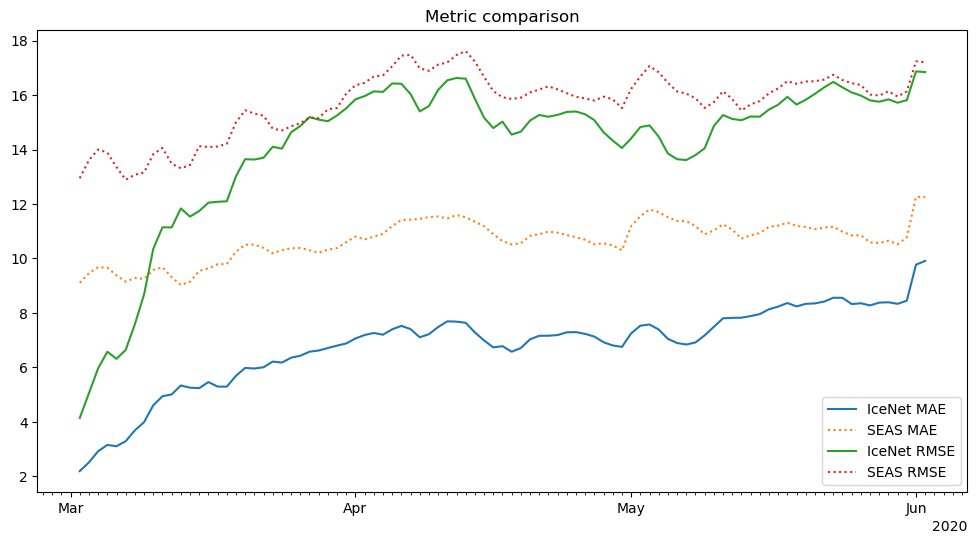

In [13]:
plot_metrics(metrics=["MAE", "RMSE"],
             masks=masks,
             fc_da=fc,
             obs_da=obs,
             cmp_da=cmp,
             output_path="plot/MAE_RMSE_comp.png")

In [ ]:
!icenet_plot_metric north "/users/rychan/icenet/pipeline/results/predict/daily_2018_2020_north.nc" "2020-03-01" \
    -o "plot/MAE_RMSE_comp.png" \
    -m "MSE" \
    -e \
    -b

### Binary accuracy metric

In [14]:
fc_binacc = compute_binary_accuracy(masks=masks,
                                    fc_da=fc,
                                    obs_da=obs,
                                    threshold=0.15)
fc_binacc

<xarray.DataArray (time: 93)>
dask.array<mul, shape=(93,), dtype=float64, chunksize=(93,), chunktype=numpy.ndarray>
Coordinates:
    Lambert_Azimuthal_Grid  int32 -2147483647
    forecast_date           (time) datetime64[ns] 2020-03-02 ... 2020-06-02
  * time                    (time) datetime64[ns] 2020-03-02 ... 2020-06-02

In [15]:
fc_binacc.values

array([98.98083494, 98.79067003, 98.41034022, 98.22017531, 98.31525776,
       98.0300104 , 97.83984549, 97.22180954, 96.88902095, 96.55623236,
       96.36606745, 95.79557272, 95.65294904, 95.36770168, 95.32016045,
       95.41524291, 95.51032536, 95.08245432, 94.65458327, 94.65458327,
       94.60704204, 94.32179468, 94.36933591, 93.98900609, 93.70375873,
       93.56113505, 93.70375873, 93.75129996, 93.84638241, 93.6562175 ,
       93.49212077, 93.58835559, 93.34776856, 92.9628293 , 92.52977265,
       92.57789005, 92.86659449, 93.01094671, 92.9147119 , 92.72224227,
       92.62600746, 92.67412486, 92.81847708, 93.34776856, 93.6845904 ,
       93.92517743, 93.6845904 , 93.92517743, 93.97329484, 93.58835559,
       93.58835559, 93.6845904 , 93.49212077, 93.58835559, 93.6845904 ,
       93.73270781, 93.58835559, 93.78082521, 93.92517743, 93.97329484,
       93.73233259, 93.47239822, 93.36842447, 93.62835884, 93.88829321,
       94.04425383, 94.0962407 , 93.99226695, 93.88829321, 93.42

INFO:root:Saving to plot/binacc_comp.png


(<xarray.DataArray (time: 93)>
 dask.array<mul, shape=(93,), dtype=float64, chunksize=(93,), chunktype=numpy.ndarray>
 Coordinates:
     Lambert_Azimuthal_Grid  int32 -2147483647
     forecast_date           (time) datetime64[ns] 2020-03-02 ... 2020-06-02
   * time                    (time) datetime64[ns] 2020-03-02 ... 2020-06-02,
 <xarray.DataArray (time: 93)>
 dask.array<mul, shape=(93,), dtype=float64, chunksize=(93,), chunktype=numpy.ndarray>
 Coordinates:
   * time     (time) datetime64[ns] 2020-03-02 2020-03-03 ... 2020-06-02)

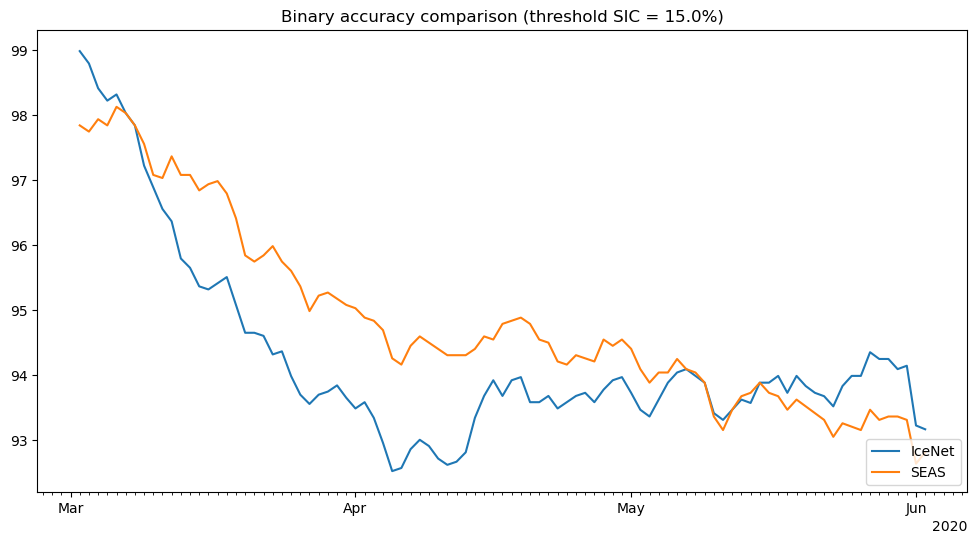

In [17]:
plot_binary_accuracy(masks=masks,
                     fc_da=fc,
                     obs_da=obs,
                     cmp_da=cmp,
                     output_path="plot/binacc_comp.png")

In [82]:
!icenet_plot_bin_accuracy -h

2023-03-14 18:59:20.823844: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 18:59:20.994394: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
usage: icenet_plot_bin_accuracy [-h] [-o OUTPUT_PATH] [-v] [-r REGION] [-b]
                                [-e] [-t THRESHOLD]
                                {north,south} forecast_file forecast_date

positional arguments:
  {north,south}
  forecast_file
  forecast_date

optional arguments:
  -h, --help            show this help message and

In [ ]:
!icenet_plot_bin_accuracy north "/users/rychan/icenet/pipeline/results/predict/daily_2018_2020_north.nc" "2020-03-01" \
    -o "plot/binacc_comp.png" \
    -e \
    -b

### Sea-ice extent metric

In [18]:
fc_sie = compute_sea_ice_extent_error(masks=masks,
                                      fc_da=fc,
                                      obs_da=obs,
                                      grid_area_size=25,
                                      threshold=0.15)
fc_sie

<xarray.DataArray (time: 93)>
dask.array<mul, shape=(93,), dtype=int64, chunksize=(93,), chunktype=numpy.ndarray>
Coordinates:
    Lambert_Azimuthal_Grid  int32 -2147483647
    forecast_date           (time) datetime64[ns] 2020-03-02 ... 2020-06-02
  * time                    (time) datetime64[ns] 2020-03-02 ... 2020-06-02

In [19]:
fc_sie.values

array([  76875,   43750,   96250,  135625,  176250,  165000,  151250,
        148125,  103750,  200000,  216875,  242500,  243750,  237500,
        273750,  261250,  281875,  251875,  321250,  453125,  478125,
        515000,  586875,  703125,  711875,  817500,  807500,  766250,
        746875,  799375,  823125,  814375,  927500, 1003125, 1061875,
       1020000,  990000, 1040000,  999375,  990625, 1023125,  948750,
        946875,  917500,  883125,  853125,  925625,  845000,  805625,
        796250,  764375,  726875,  731875,  755625,  748750,  700000,
        696875,  616875,  558125,  542500,  520625,  521250,  539375,
        541250,  540625,  554375,  560000,  595625,  608125,  677500,
        688750,  681875,  739375,  760625,  758750,  784375,  801875,
        843750,  801250,  771250,  836250,  820625,  833750,  799375,
        739375,  684375,  668750,  641875,  686250,  675000,  718750,
        720000,  733125])

INFO:root:Saving to plot/SIE_comp.png


(<xarray.DataArray (time: 93)>
 dask.array<mul, shape=(93,), dtype=int64, chunksize=(93,), chunktype=numpy.ndarray>
 Coordinates:
     Lambert_Azimuthal_Grid  int32 -2147483647
     forecast_date           (time) datetime64[ns] 2020-03-02 ... 2020-06-02
   * time                    (time) datetime64[ns] 2020-03-02 ... 2020-06-02,
 <xarray.DataArray (time: 93)>
 dask.array<mul, shape=(93,), dtype=int64, chunksize=(93,), chunktype=numpy.ndarray>
 Coordinates:
   * time     (time) datetime64[ns] 2020-03-02 2020-03-03 ... 2020-06-02)

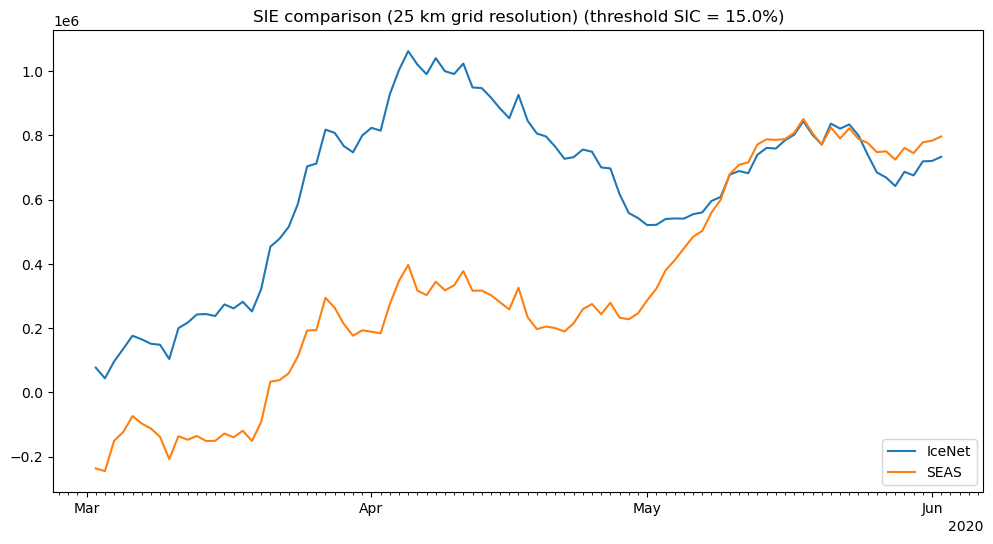

In [20]:
plot_sea_ice_extent_error(masks=masks,
                          fc_da=fc,
                          obs_da=obs,
                          cmp_da=cmp,
                          output_path="plot/SIE_comp.png")

In [ ]:
!icenet_plot_sie_error north "/users/rychan/icenet/pipeline/results/predict/daily_2018_2020_north.nc" "2020-03-01" \
    -o "plot/binaSIE_compcc_comp.png" \
    -e \
    -b

## Leadtime averaged metrics and plots



In [21]:
rmse_leadtime_avg_df = compute_metrics_leadtime_avg(metric="RMSE",
                                                      masks=masks,
                                                      hemisphere="north",
                                                      forecast_file=forecast_file,
                                                      emcwf=False,
                                                      data_path="metrics/RMSE_leadtime_avg.csv",
                                                      threshold=0.15)

In [22]:
rmse_leadtime_avg_df

,Unnamed: 0,date,dayofyear,month,target_date,target_dayofyear,target_month,leadtime,RMSE,forecast_name
0,0,2018-01-01,1,1,2018-01-02,2,1,1,4.234488,IceNet
1,1,2018-01-01,1,1,2018-01-03,3,1,2,5.147462,IceNet
2,2,2018-01-01,1,1,2018-01-04,4,1,3,6.004297,IceNet
3,3,2018-01-01,1,1,2018-01-05,5,1,4,6.562929,IceNet
4,4,2018-01-01,1,1,2018-01-06,6,1,5,7.107866,IceNet
...,...,...,...,...,...,...,...,...,...,...
101923,88,2020-12-31,365,12,2021-03-30,89,3,89,12.237754,IceNet
101924,89,2020-12-31,365,12,2021-03-31,90,3,90,11.812640,IceNet
101925,90,2020-12-31,365,12,2021-04-01,91,4,91,11.725054,IceNet
101926,91,2020-12-31,365,12,2021-04-02,92,4,92,12.121185,IceNet


INFO:root:Attempting to read in metrics dataframe from metrics/RMSE_leadtime_avg.csv
INFO:root:Creating leadtime averaged plot for RMSE metric
INFO:root:Saving to plot/RMSE_leadtime_avg_all.png


(        Unnamed: 0       date  dayofyear  month target_date  target_dayofyear  \
 0                0 2018-01-01          1      1  2018-01-02                 2   
 1                1 2018-01-01          1      1  2018-01-03                 3   
 2                2 2018-01-01          1      1  2018-01-04                 4   
 3                3 2018-01-01          1      1  2018-01-05                 5   
 4                4 2018-01-01          1      1  2018-01-06                 6   
 ...            ...        ...        ...    ...         ...               ...   
 101923          88 2020-12-31        365     12  2021-03-30                89   
 101924          89 2020-12-31        365     12  2021-03-31                90   
 101925          90 2020-12-31        365     12  2021-04-01                91   
 101926          91 2020-12-31        365     12  2021-04-02                92   
 101927          92 2020-12-31        365     12  2021-04-03                93   
 
         targe

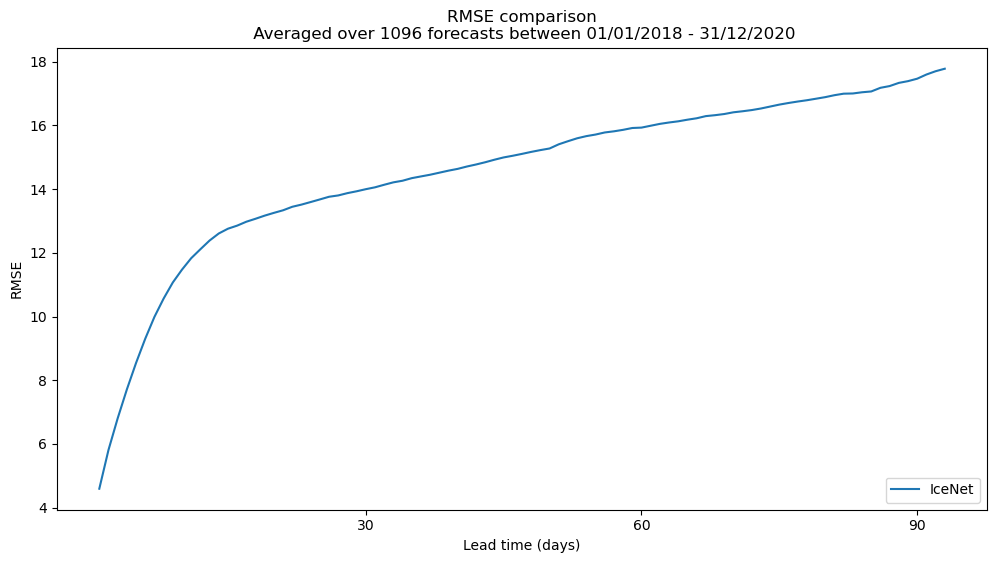

In [39]:
plot_metrics_leadtime_avg(metric="RMSE",
                          masks=masks,
                          hemisphere="north",
                          forecast_file=forecast_file,
                          emcwf=False,
                          output_path="plot/RMSE_leadtime_avg_all.png",
                          average_over="all",
                          data_path="metrics/RMSE_leadtime_avg.csv")

In [25]:
!icenet_plot_leadtime_avg -h

2023-03-14 10:45:36.365293: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 10:45:36.524971: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
usage: icenet_plot_leadtime_avg [-h] [-o OUTPUT_PATH] [-v] [-r REGION] [-b]
                                [-e] [-m METRIC] [-dp DATA_PATH]
                                [-ao {all,month,day}] [-td]
                                {north,south} forecast_file

positional arguments:
  {north,south}
  forecast_file

optional arguments:
  -h, -

In [41]:
!icenet_plot_leadtime_avg north "/users/rychan/icenet/pipeline/results/predict/biweekly_16_20_north.nc" \
    -m "RMSE" \
    -dp "metrics/RMSE_leadtime_avg.csv" \
    -ao "month"

2023-03-14 16:59:02.835177: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 16:59:03.021000: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
INFO:root:Attempting to read in metrics dataframe from metrics/RMSE_leadtime_avg.csv
INFO:root:Creating leadtime averaged plot for RMSE metric
INFO:root:Saving to plot/leadtime_averaged_init_month_RMSE.png


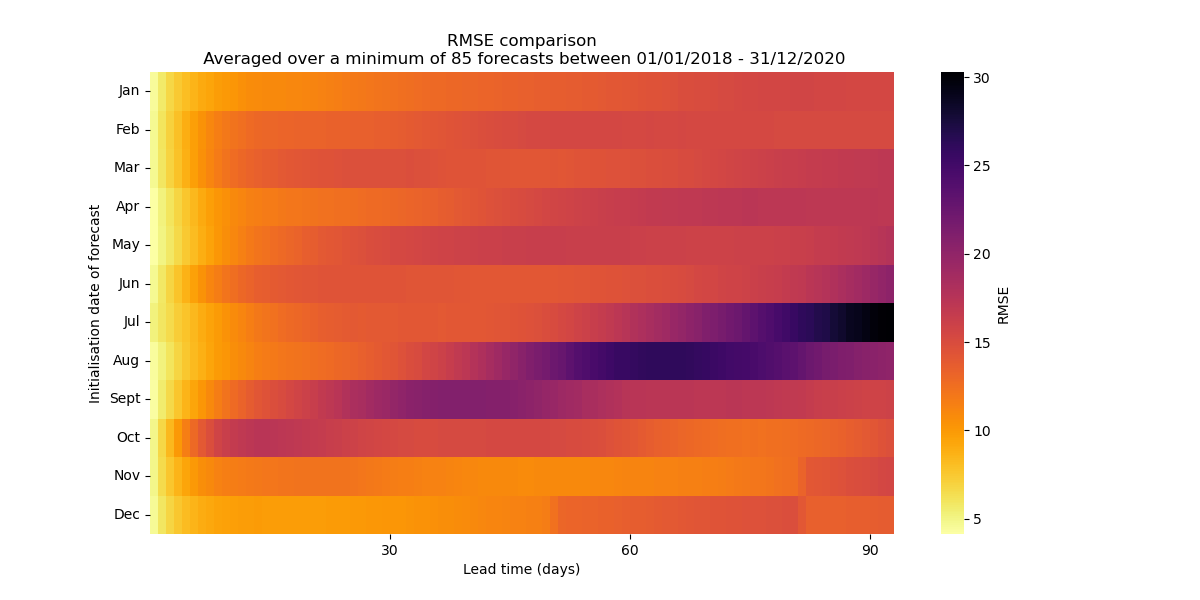

In [42]:
Image("plot/leadtime_averaged_init_month_RMSE.png")

In [43]:
!icenet_plot_leadtime_avg north "/users/rychan/icenet/pipeline/results/predict/daily_2018_2020_north.nc" \
    -m "RMSE" \
    -dp "metrics/RMSE_leadtime_avg.csv" \
    -ao "day"

2023-03-14 16:59:39.369064: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 16:59:39.570671: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
INFO:root:Attempting to read in metrics dataframe from metrics/RMSE_leadtime_avg.csv
INFO:root:Creating leadtime averaged plot for RMSE metric
INFO:root:Saving to plot/leadtime_averaged_init_day_RMSE.png


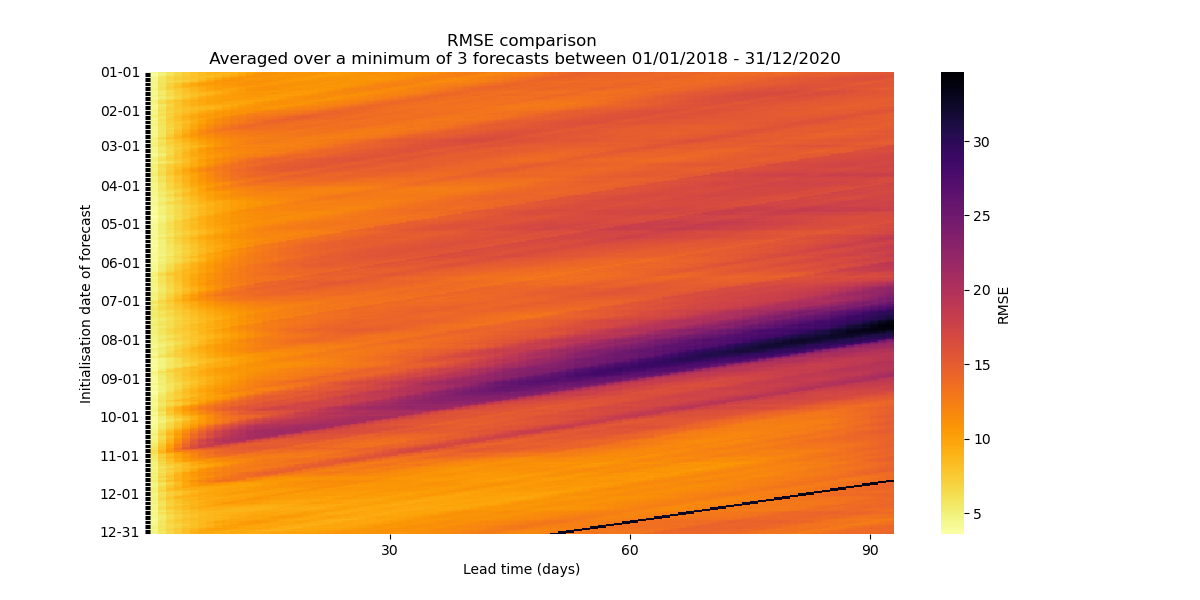

In [44]:
Image("plot/leadtime_averaged_init_day_RMSE.png")

In [45]:
!icenet_plot_leadtime_avg north "/users/rychan/icenet/pipeline/results/predict/daily_2018_2020_north.nc" \
    -m "RMSE" \
    -dp "metrics/RMSE_leadtime_avg.csv" \
    -ao "day" \
    -td

2023-03-14 16:59:46.549105: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 16:59:46.718295: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
INFO:root:Attempting to read in metrics dataframe from metrics/RMSE_leadtime_avg.csv
INFO:root:Creating leadtime averaged plot for RMSE metric
INFO:root:Saving to plot/leadtime_averaged_target_day_RMSE.png


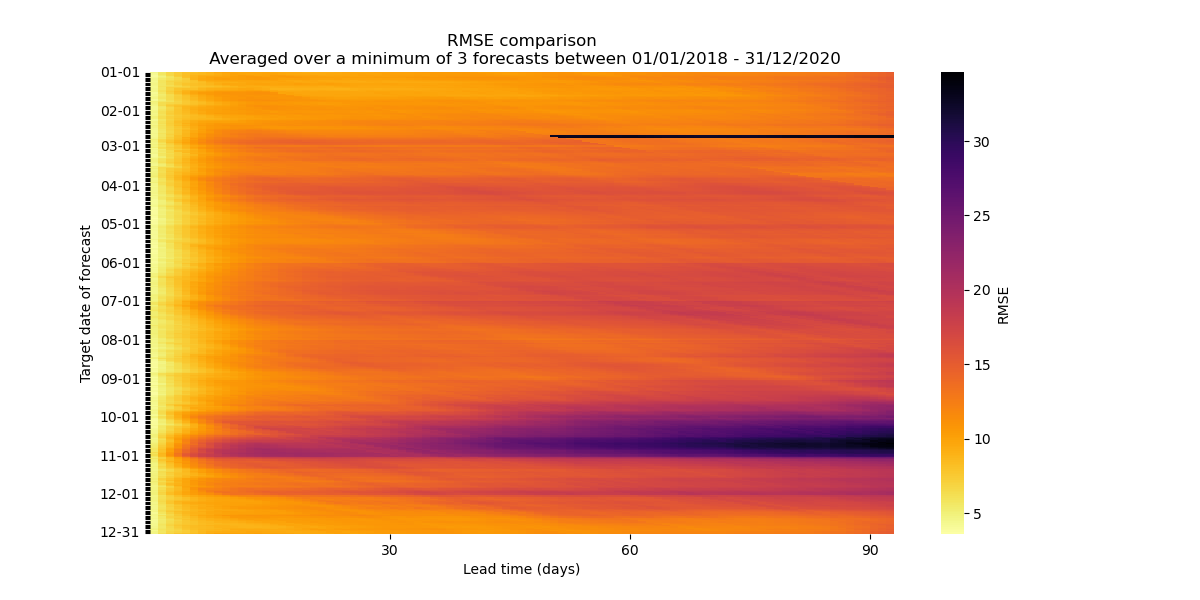

In [46]:
Image("plot/leadtime_averaged_target_day_RMSE.png")

In [47]:
!icenet_plot_leadtime_avg north "/users/rychan/icenet/pipeline/results/predict/daily_2018_2020_north.nc" \
    -m "RMSE" \
    -dp "metrics/RMSE_leadtime_avg_comp.csv" \
    -ao "all" \
    -e

2023-03-14 16:59:53.060219: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 16:59:53.215664: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
INFO:root:Attempting to read in metrics dataframe from metrics/RMSE_leadtime_avg_comp.csv
INFO:root:Couldn't load in dataframe from metrics/RMSE_leadtime_avg_comp.csv, will compute metric dataframe and try save to metrics/RMSE_leadtime_avg_comp.csv
INFO:root:Computing RMSE for 7 forecasts
INFO:root:Got files: ['./data/osisaf/north/siconca/201

In [49]:
Image("plot/leadtime_averaged_all_RMSE_comp.png")

FileNotFoundError: No such file or directory: 'plot/leadtime_averaged_all_RMSE_comp.png'

FileNotFoundError: No such file or directory: 'plot/leadtime_averaged_all_RMSE_comp.png'

<IPython.core.display.Image object>

In [48]:
!icenet_plot_leadtime_avg north "/users/rychan/icenet/pipeline/results/predict/daily_2018_2020_north.nc" \
    -m "RMSE" \
    -dp "metrics/RMSE_leadtime_avg_comp.csv" \
    -ao "month" \
    -e

2023-03-14 17:00:25.036838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 17:00:25.206746: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
INFO:root:Attempting to read in metrics dataframe from metrics/RMSE_leadtime_avg_comp.csv
INFO:root:Creating leadtime averaged plot for RMSE metric
INFO:root:Saving to plot/leadtime_averaged_init_month_RMSE_comp.png


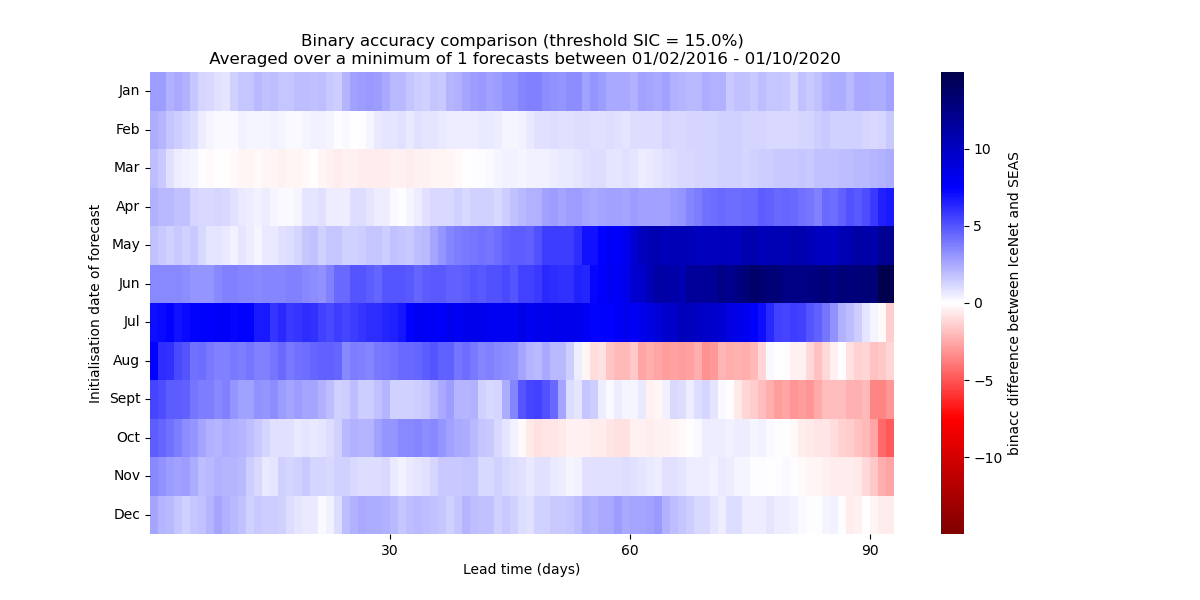

In [35]:
Image("plot/leadtime_averaged_init_month_RMSE_comp.png")

In [ ]:
!icenet_plot_leadtime_avg north "/users/rychan/icenet/pipeline/results/predict/daily_2018_2020_north.nc" \
    -m "RMSE" \
    -dp "metrics/RMSE_leadtime_avg_comp.csv" \
    -ao "day" \
    -e

2023-03-13 17:18:47.481423: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 17:18:47.651468: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
INFO:root:Attempting to read in metrics dataframe from metrics/binacc_leadtime_avg_comp.csv
INFO:root:Creating leadtime averaged plot for binacc metric
INFO:root:Saving to plot/binacc_leadtime_avg_day_comp.png


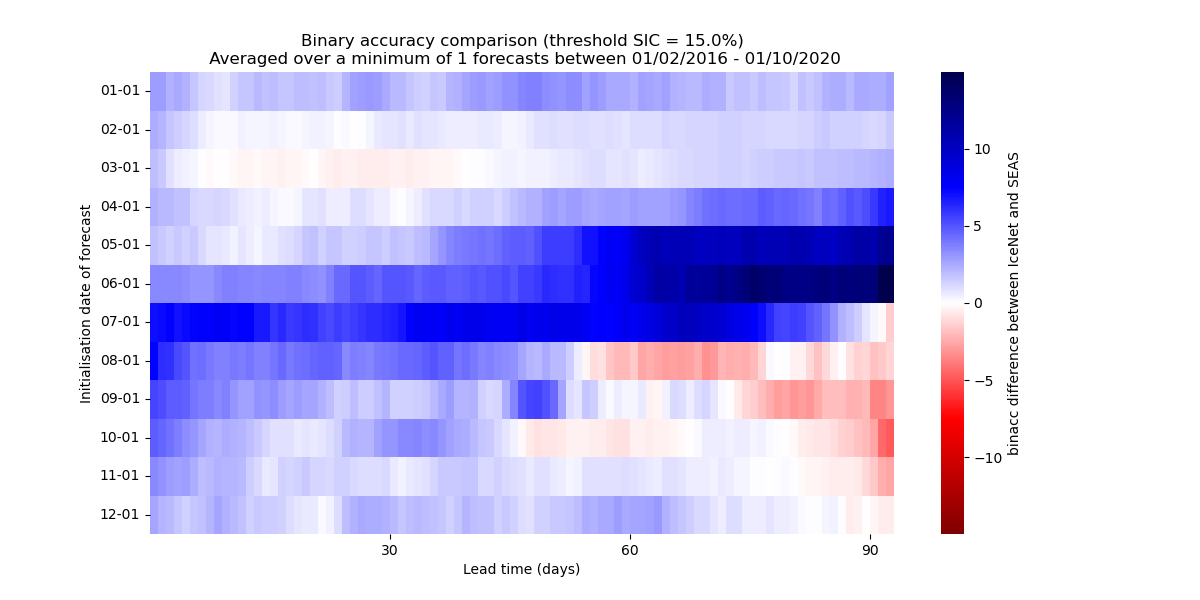

In [46]:
Image("plot/binacc_leadtime_avg_day_comp.png")